# BahuBhashi

## What is BahuBhashi?

Recently many MNC’s are facing an issue where a customer of a particular region calls in and the customer experiences long wait hours as all the representatives are busy. While their call centers in other regions are not experiencing busy wait hours. To mitigate this issue there could be a system designed which takes an audio input in one language and translates it into another language. This solution could be used where if the call centers in one region are facing high call volumes the calls could be directed to the regions facing lower call volumes and BahuBhashi could be used so that person on both ends can converse in their own language and find a solution to their issue. 

## What are the requirements?

• Operating System: Windows 10/ macOS High Sierra

• Dataset: Google speech command dataset (https://www.kaggle.com/c/tensorflow-speech-recognition-challenge/data) 

• Python: v3.6.2

• Librosa

• Scipy

• PIL


## How does the translation take place?

Speech-to-text was modelled by using the features from the audio files. Package ‘librosa’ is used to load the audio files with a particular sample rate. Each of the samples are used as a feature input to a Convolution 1D layer. It is followed by a series of Batch Normalization, Max Pooling and Dropout layers. A complex model was built with around 16 sets of Convolution layers and 3 fully connected layers. The audio samples, when passed through this network, let the network extract relevant information about the MFCCsfeatures and the amplitude of the waveform and train itself for various samples of a same class. A softmax activation is used at the last layer to get the max probability out of all the classes. The model has close to 138,000,000 parameters and is a complex model.

## Imports 

In [1]:
import tensorflow as tf
import keras
from keras.utils import multi_gpu_model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv1D, MaxPooling1D, BatchNormalization, Conv2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.models import load_model
from sklearn.cross_validation import train_test_split
from keras.optimizers import Adam, SGD
from keras.utils import np_utils
import sklearn
from sklearn import metrics
import librosa
import matplotlib.pyplot as plt
from matplotlib.backend_bases import RendererBase
from scipy import signal
from scipy.io import wavfile
import os
from os.path import isdir, join
from sklearn.preprocessing import LabelEncoder
import numpy as np
from PIL import Image
from scipy.fftpack import fft
import copy
import random
import librosa.display
import glob
plt.style.use('ggplot')
%matplotlib inline

F:\anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
F:\anaconda\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Setting the audio and picture path and displaying the words in the given subfolder of the dataset 

In [3]:
audio_path = 'audio/'
pict_Path = 'pics/'
samples = []

In [4]:
subFolderList = []
for x in os.listdir(audio_path):
    if os.path.isdir(audio_path + '/' + x):
        subFolderList.append(x)

In [5]:
subFolderList

['bed',
 'yes',
 'stop',
 'no',
 'three',
 'right',
 'one',
 'four',
 '_background_noise_',
 'two',
 'up',
 'left',
 'five',
 'cat',
 'dog',
 'eight',
 'bird',
 'happy',
 'on',
 'down',
 'sheila',
 'zero',
 'wow',
 'marvin',
 'house',
 'six',
 'off',
 'seven',
 'tree',
 'nine',
 'go']

In [5]:
if not os.path.exists(pict_Path):
    os.makedirs(pict_Path)

subFolderList = []
for x in os.listdir(audio_path):
    if os.path.isdir(audio_path + '/' + x):
        subFolderList.append(x)
        if not os.path.exists(pict_Path + '/' + x):
            os.makedirs(pict_Path +'/'+ x)

In [6]:
sample_audio = []
total = 0
for x in subFolderList:
    
    # get all the .wav files
    all_files = [y for y in os.listdir(audio_path + x) if '.wav' in y]
    total += len(all_files)
    # collect the first file from each dir
    sample_audio.append(audio_path  + x + '/'+ all_files[0])
    
    # show file counts
    print('count: %d : %s' % (len(all_files), x ))
print(total)

count: 1713 : bed
count: 2377 : yes
count: 2380 : stop
count: 2375 : no
count: 2356 : three
count: 2367 : right
count: 2370 : one
count: 2372 : four
count: 6 : _background_noise_
count: 2373 : two
count: 2375 : up
count: 2353 : left
count: 2357 : five
count: 1733 : cat
count: 1746 : dog
count: 2352 : eight
count: 1731 : bird
count: 1742 : happy
count: 2367 : on
count: 2359 : down
count: 1734 : sheila
count: 2376 : zero
count: 1745 : wow
count: 1746 : marvin
count: 1750 : house
count: 2369 : six
count: 2357 : off
count: 2377 : seven
count: 1733 : tree
count: 2364 : nine
count: 2372 : go
64727


In [7]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, _, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, np.log(spec.T.astype(np.float32) + eps)

## Creating the spectogram

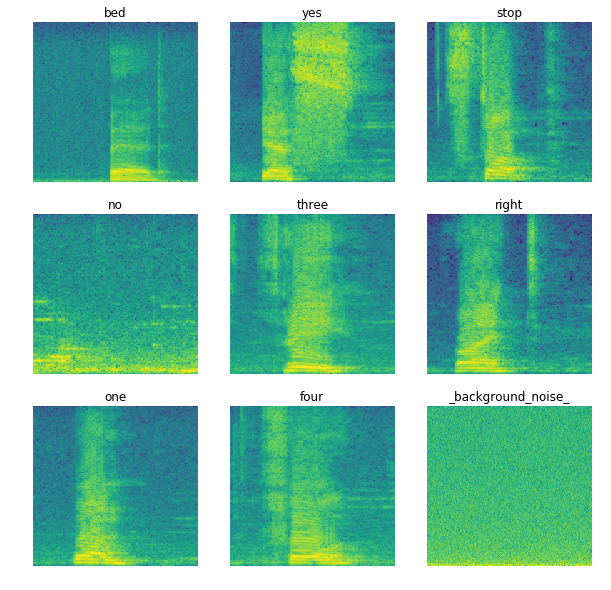

In [22]:
fig = plt.figure(figsize=(10,10))

# for each of the samples
for i, filepath in enumerate(sample_audio[:9]):
    # Make subplots
    plt.subplot(3,3,i+1)
    
    # pull the labels
    label = filepath.split('/')[-2]
    plt.title(label)
    
    # create spectogram
    samplerate, test_sound  = wavfile.read(filepath)
    _, spectrogram = log_specgram(test_sound, samplerate)
    
    plt.imshow(spectrogram.T, aspect='auto', origin='lower')
    plt.axis('off')

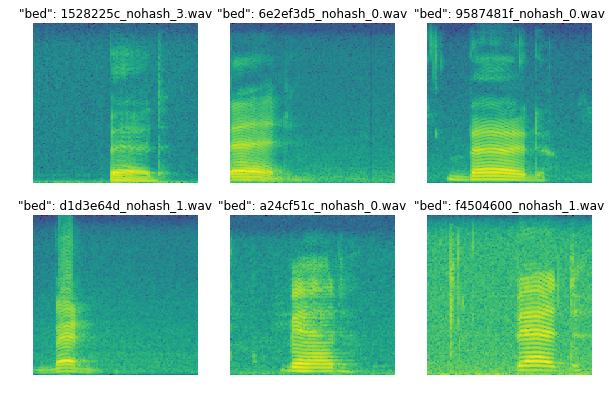

In [23]:
bed_samples = [audio_path + 'bed/' + y for y in os.listdir(audio_path + 'bed/')[:6]]

fig = plt.figure(figsize=(10,10))

for i, filepath in enumerate(bed_samples):
    # Make subplots
    plt.subplot(3,3,i+1)
    
    # pull the labels
    label = filepath.split('/')[-1]
    plt.title('"bed": '+label)
    
    # create spectogram
    # create spectogram
    samplerate, test_sound  = wavfile.read(filepath)
    _, spectrogram = log_specgram(test_sound, samplerate)
    
    plt.imshow(spectrogram.T, aspect='auto', origin='lower')
    plt.axis('off')

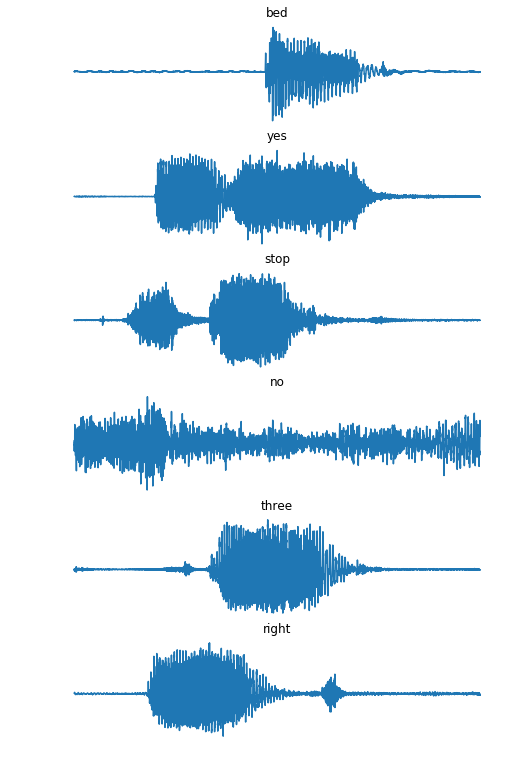

In [24]:
fig = plt.figure(figsize=(8,20))
for i, filepath in enumerate(sample_audio[:6]):
    plt.subplot(9,1,i+1)
    samplerate, test_sound  = wavfile.read(filepath)
    plt.title(filepath.split('/')[-2])
    plt.axis('off')
    plt.plot(test_sound)

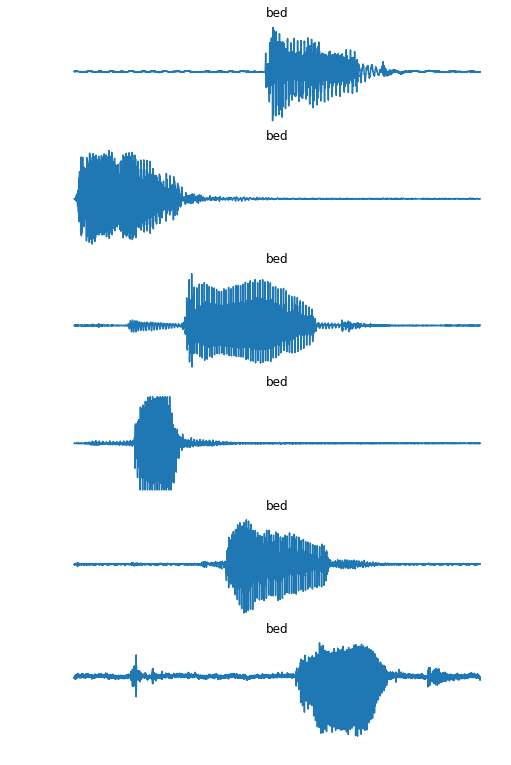

In [25]:
fig = plt.figure(figsize=(8,20))
for i, filepath in enumerate(bed_samples):
    plt.subplot(9,1,i+1)
    samplerate, test_sound = wavfile.read(filepath)
    plt.title(filepath.split('/')[-2])
    plt.axis('off')
    plt.plot(test_sound)

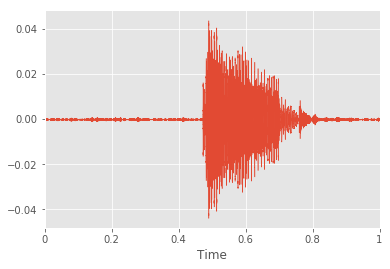

In [7]:
x, fs = librosa.load('audio/bed/1528225c_nohash_3.wav')
librosa.display.waveplot(x, sr=fs)

## Extracting MFCC features using librosa

In [8]:
mfcc_fe = librosa.feature.mfcc(x, sr=fs)
mfcc_fe.shape

(20, 44)

In this case, mfcc computed 20 MFCCs

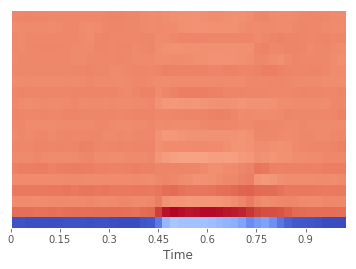

In [9]:
librosa.display.specshow(mfcc_fe, sr=fs, x_axis='time')

Let's scale the MFCCs such that each coefficient dimension has zero mean and unit variance:

In [12]:
mfcc_fe = sklearn.preprocessing.scale(mfcc_fe, axis=1)
print (mfcc_fe.mean(axis=1))
print (mfcc_fe.var(axis=1))

[-3.45683078e-16 -4.36519507e-16  7.94818756e-17  6.43424707e-16
  2.01858732e-17  0.00000000e+00  1.11022302e-16 -9.08364293e-17
  3.53252781e-17  9.90369403e-17 -1.16068771e-16  4.54182146e-17
  6.99724369e-16  4.03717464e-17  2.01858732e-17 -3.02788098e-17
 -5.86651939e-17  8.33928886e-16  2.27091073e-17  1.18592005e-16]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


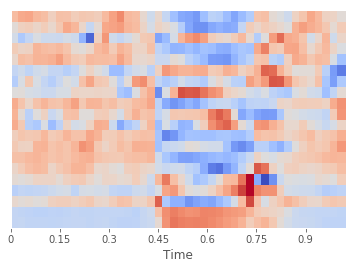

In [19]:
librosa.display.specshow(mfcc_fe, sr=fs, x_axis='time')

In [20]:
def windows(data, window_size):
    start = 0
    while start < len(data):
        yield start, start + window_size
        start += (window_size / 2)

def extract_features(parent_dir,sub_dirs,file_ext="*.wav",bands = 60, frames = 41):
#     window_size = 512 * (frames - 1)
    features = []
    labels = []
    for l, sub_dir in enumerate(sub_dirs):
        for fn in glob.glob(os.path.join(parent_dir, sub_dir, file_ext)):
            sound_clip,s = librosa.load(fn)
            mfccs = np.mean(librosa.feature.mfcc(y=sound_clip, sr=s, n_mfcc=40).T,axis=0) 
            label = fn.split('/')[1]
            labels.append(label)
            features.append(mfccs)
    return [features, labels]

def one_hot_encode(labels):
    n_labels = len(labels)
    n_unique_labels = len(np.unique(labels))
    one_hot_encode = np.zeros((n_labels,n_unique_labels))
    one_hot_encode[np.arange(n_labels), labels] = 1
    return one_hot_encode

In [21]:
parent_dir = 'audio'
tr_sub_dirs= ['audio']
tr_features,tr_labels = extract_features(parent_dir, subFolderList)

In [23]:
len(tr_labels)

64727

In [24]:
tr_features[0]

array([-6.27701528e+02,  9.91942229e+01, -2.62841814e-01,  4.57046266e+01,
       -4.37777359e-01,  1.95596912e+01, -1.21316956e+01,  5.69437818e+00,
       -4.62869489e-01,  4.69296136e+00,  1.00857102e+01, -5.30544646e+00,
        1.33931536e+01,  2.66754340e+00,  1.30918976e+01,  1.67369250e+00,
        3.55686912e+00,  9.12118486e+00,  9.17770042e-01,  3.42081638e+00,
       -2.45751956e+00,  3.59362088e+00, -6.05301256e-01,  6.64407311e-01,
        1.04309306e-01,  1.38379879e+00,  3.26011514e-01, -8.17581773e-01,
        1.85662337e+00, -2.63226142e+00,  1.92221192e+00, -1.31543907e+00,
       -6.35496696e-01,  8.57673175e-01,  2.03593872e+00,  2.17921492e+00,
        4.34757935e-02,  1.93893665e+00, -3.97743386e-01,  1.07653124e+00])

In [25]:
X = np.array(tr_features)
y = np.array(tr_labels)
lb = LabelEncoder()
y = np_utils.to_categorical(lb.fit_transform(y))

In [26]:
print(y)

[[0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [27]:
y.shape

(64727, 31)

In [28]:
X.shape

(64727, 40)

## Splitting the train split data

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, train_size=0.8)
X_train, x_cv, y_train, y_cv = train_test_split(X_train,y_train,test_size = 0.25,train_size =0.75)

## Building the model

In [34]:
num_labels = y.shape[1]
filter_size = 2

# build model
model = Sequential()

model.add(Dense(64, input_shape=(40,), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(num_labels))
model.add(Activation('softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 64)                2624      
_________________________________________________________________
batch_normalization_3 (Batch (None, 64)                256       
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               8320      
_________________________________________________________________
batch_normalization_4 (Batch (None, 128)               512       
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               33024     
__________

## Hyperparameter tunning 

In [41]:
adam = Adam(lr=0.1)
filepath="model_weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.2, patience=15, min_lr=0.001)
earlyStopping = EarlyStopping(monitor='val_acc', patience=7)
callbacks_list = [reduce_lr, checkpoint, earlyStopping]
parallel_model = multi_gpu_model(model, gpus=4)
parallel_model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=adam)

In [43]:
history = parallel_model.fit(X_train, y_train, batch_size=32, epochs=100,
                    validation_data = (x_cv,y_cv),callbacks = callbacks_list)
# mod = model.fit(X,y,batch_size= 128, epochs= 50)

Train on 38835 samples, validate on 12946 samples
Epoch 1/100
38835/38835 [==============================] - 33s 861us/step - loss: 0.1677 - acc: 0.9661 - val_loss: 0.1984 - val_acc: 0.9648

Epoch 00001: val_acc improved from -inf to 0.96480, saving model to model_weights.best.hdf5
Epoch 2/100
38835/38835 [==============================] - 31s 787us/step - loss: 0.1638 - acc: 0.9660 - val_loss: 0.1694 - val_acc: 0.9592

Epoch 00002: val_acc did not improve from 0.96480
Epoch 3/100
38835/38835 [==============================] - 31s 793us/step - loss: 0.1611 - acc: 0.9660 - val_loss: 0.1474 - val_acc: 0.9676

Epoch 00003: val_acc improved from 0.96480 to 0.96759, saving model to model_weights.best.hdf5
Epoch 4/100
38835/38835 [==============================] - 31s 786us/step - loss: 0.1613 - acc: 0.9661 - val_loss: 0.1613 - val_acc: 0.9677

Epoch 00004: val_acc improved from 0.96759 to 0.96770, saving model to model_weights.best.hdf5
Epoch 5/100
38835/38835 [=============================

## Plotting the accuracy and loss graph 

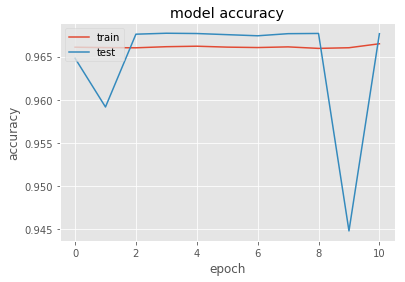

In [44]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

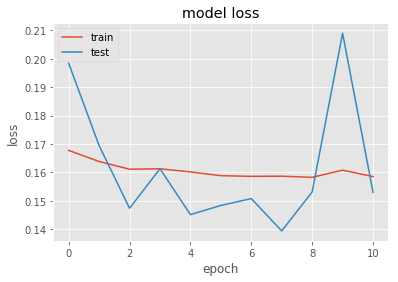

In [45]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Predictions on test dataset  

In [46]:
pred = parallel_model.predict(X_test)

In [48]:
pred[0]

array([3.7856453e-24, 6.0737767e-04, 1.9370265e-02, 1.1912708e-02,
       3.5189854e-03, 2.8135512e-02, 4.7414922e-04, 2.7698928e-02,
       1.3319748e-02, 2.3569990e-02, 4.1345027e-03, 2.6604781e-02,
       8.7198475e-03, 4.0523559e-03, 1.1633437e-03, 1.6682183e-02,
       1.4285347e-01, 8.4620386e-02, 5.6360014e-02, 4.0206581e-02,
       5.8655734e-03, 9.0872310e-04, 5.4441916e-04, 2.9691103e-01,
       1.2673840e-03, 1.7761588e-03, 2.1736285e-02, 1.3255467e-01,
       1.1680162e-02, 1.2382908e-02, 3.6754902e-04], dtype=float32)

In [49]:
max(pred[0])

0.29691103

In [50]:
sum(pred[0])

0.9999999867577571

In [63]:
sc,sr = librosa.load('output.wav')
mfccs_test = np.mean(librosa.feature.mfcc(y=sc, sr=sr, n_mfcc=40).T,axis=0)
sc2,sr2 = librosa.load('output2.wav')
mfccs_test2 = np.mean(librosa.feature.mfcc(y=sc2, sr=sr2, n_mfcc=40).T,axis=0)

In [65]:
feat_test = []
feat_test.append(mfccs_test)
feat_test.append(mfccs_test2)
feat_test_arr = np.array(feat_test)

In [66]:
feat_test_arr.shape

(2, 40)

In [67]:
out_test = parallel_model.predict(feat_test_arr)

**-----------------------**

In [2]:
train_audio_path = 'audio/'
print(os.listdir(train_audio_path))

['bed', 'yes', 'stop', 'no', 'three', 'right', 'one', 'four', '_background_noise_', 'two', 'up', 'left', 'five', 'cat', 'dog', 'eight', 'bird', 'happy', 'on', 'down', 'sheila', 'zero', 'wow', 'marvin', 'house', 'six', 'off', 'seven', 'tree', 'nine', 'go']


In [3]:
dirs = [f for f in os.listdir(train_audio_path) if isdir(join(train_audio_path, f))]
dirs.sort()
all_wav = []
label_all = []
label_value = {}
target_list = [d for d in dirs if d != '_background_noise_' ]
print('target_list : ',end='')
print(target_list)
print('silence : _background_noise_')
i=0;
background = [f for f in os.listdir(join(train_audio_path, '_background_noise_')) if f.endswith('.wav')]
background_noise = []
for wav in background : 
    samples, sample_rate = librosa.load(join(join(train_audio_path,'_background_noise_'),wav))
    samples = librosa.resample(samples, sample_rate, 8000)
    background_noise.append(samples)

for direct in dirs[1:]:
    waves = [f for f in os.listdir(join(train_audio_path, direct)) if f.endswith('.wav')]
    label_value[direct] = i
    i = i + 1
    print(str(i)+":" +str(direct) + " ", end="")
    for wav in waves:
        samples, sample_rate = librosa.load(join(join(train_audio_path,direct),wav), sr = 8000)
        samples = librosa.resample(samples, sample_rate, 8000)
        if len(samples) != 8000 : 
            continue
        label_all.append(direct)
        all_wav.append([samples, direct])

target_list : ['bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'four', 'go', 'happy', 'house', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'wow', 'yes', 'zero']
silence : _background_noise_
1:bed 2:bird 3:cat 4:dog 5:down 6:eight 7:five 8:four 9:go 10:happy 11:house 12:left 13:marvin 14:nine 15:no 16:off 17:on 18:one 19:right 20:seven 21:sheila 22:six 23:stop 24:three 25:tree 26:two 27:up 28:wow 29:yes 30:zero 

In [41]:
all_wav[0]

[array([ 5.4213397e-05,  2.1128367e-04,  9.1667389e-05, ...,
        -1.8294323e-04, -1.2447845e-04, -5.4811313e-05], dtype=float32), 'bed']

In [42]:
wav_all = np.reshape(np.delete(all_wav,1,1),(len(all_wav)))

In [43]:
label_all = [i for i in np.delete(all_wav,0,1).tolist()]
label_all

[['bed'],
 ['bed'],
 ['bed'],
 ['bed'],
 ['bed'],
 ['bed'],
 ['bed'],
 ['bed'],
 ['bed'],
 ['bed'],
 ['bed'],
 ['bed'],
 ['bed'],
 ['bed'],
 ['bed'],
 ['bed'],
 ['bed'],
 ['bed'],
 ['bed'],
 ['bed'],
 ['bed'],
 ['bed'],
 ['bed'],
 ['bed'],
 ['bed'],
 ['bed'],
 ['bed'],
 ['bed'],
 ['bed'],
 ['bed'],
 ['bed'],
 ['bed'],
 ['bed'],
 ['bed'],
 ['bed'],
 ['bed'],
 ['bed'],
 ['bed'],
 ['bed'],
 ['bed'],
 ['bed'],
 ['bed'],
 ['bed'],
 ['bed'],
 ['bed'],
 ['bed'],
 ['bed'],
 ['bed'],
 ['bed'],
 ['bed'],
 ['bed'],
 ['bed'],
 ['bed'],
 ['bed'],
 ['bed'],
 ['bed'],
 ['bed'],
 ['bed'],
 ['bed'],
 ['bed'],
 ['bed'],
 ['bed'],
 ['bed'],
 ['bed'],
 ['bed'],
 ['bed'],
 ['bed'],
 ['bed'],
 ['bed'],
 ['bed'],
 ['bed'],
 ['bed'],
 ['bed'],
 ['bed'],
 ['bed'],
 ['bed'],
 ['bed'],
 ['bed'],
 ['bed'],
 ['bed'],
 ['bed'],
 ['bed'],
 ['bed'],
 ['bed'],
 ['bed'],
 ['bed'],
 ['bed'],
 ['bed'],
 ['bed'],
 ['bed'],
 ['bed'],
 ['bed'],
 ['bed'],
 ['bed'],
 ['bed'],
 ['bed'],
 ['bed'],
 ['bed'],
 ['bed'],
 ['bed'],


For Data Augmentation. we will mix train wav, and same length(1 sec) noise(10%) from '_backgroundnoise'

In [44]:
#Random pick start point
def get_one_noise(noise_num = 0):
    selected_noise = background_noise[noise_num]
    start_idx = random.randint(0, len(selected_noise)- 1 - 8000)
    return selected_noise[start_idx:(start_idx + 8000)]

In [45]:
max_ratio = 0.1
noised_wav = []
augment = 1
delete_index = []
for i in range(augment):
    new_wav = []
    noise = get_one_noise(i)
    for i, s in enumerate(wav_all):
        if len(s) != 8000:
            delete_index.append(i)
            continue
        s = s + (max_ratio * noise)
        noised_wav.append(s)
np.delete(wav_all, delete_index)
np.delete(label_all, delete_index)

array(['bed', 'bed', 'bed', ..., 'zero', 'zero', 'zero'], dtype='<U6')

In [46]:
wav_vals = np.array([x for x in wav_all])
label_vals = [x for x in label_all]
wav_vals.shape

(58252, 8000)

In [47]:
labels = copy.deepcopy(label_vals)
for _ in range(augment):
    label_vals = np.concatenate((label_vals, labels), axis = 0)
label_vals = label_vals.reshape(-1,1)

In [48]:
#silence audio
silence_wav = []
num_wav = (2000*(augment+1))//len(background_noise)
for i, _ in enumerate(background_noise):
    for _ in range((2000*(augment+1))//len(background_noise)):
        silence_wav.append(get_one_noise(i))
silence_wav = np.array(silence_wav)
silence_label = np.array(['silence' for _ in range(num_wav*len(background_noise))])
silence_label = silence_label.reshape(-1,1)
silence_wav.shape

(3996, 8000)

In [49]:
wav_vals = np.reshape(wav_vals,(-1, 8000))
noised_wav = np.reshape(noised_wav,(-1, 8000))
silence_wav = np.reshape(silence_wav,(-1, 8000))

In [50]:
print(wav_vals.shape)
print(noised_wav.shape)
print(silence_wav.shape)

(58252, 8000)
(58252, 8000)
(3996, 8000)


In [51]:
print(label_vals.shape)
print(silence_label.shape)

(116504, 1)
(3996, 1)


In [52]:
wav_vals = np.concatenate((wav_vals, silence_wav), axis = 0)
wav_vals = np.concatenate((wav_vals, noised_wav), axis = 0)

In [53]:
label_vals = np.concatenate((label_vals, silence_label), axis = 0)

In [54]:
train_wav, test_wav, train_label, test_label = train_test_split(wav_vals, label_vals, test_size=0.2, random_state = 2)
train_wav, cv_wav, train_label, cv_label = train_test_split(train_wav, train_label, test_size=0.25, random_state = 2)

In [56]:
print(wav_vals.shape)
print(label_vals.shape)

(120500, 8000)
(120500, 1)


In [57]:
train_wav = train_wav.reshape(-1,8000,1)
cv_wav = cv_wav.reshape(-1, 8000, 1)
test_wav = test_wav.reshape(-1,8000,1)

In [62]:
label_value = target_list

In [66]:
new_label_value = dict()
for i, l in enumerate(label_value):
    new_label_value[l] = i
label_value = new_label_value

In [67]:
#Make Label data 'string' -> 'class num'
temp = []
for v in train_label:
    temp.append(label_value[v[0]])
train_label = np.array(temp)

temp = []
for v in cv_label:
    temp.append(label_value[v[0]])
cv_label = np.array(temp)

temp = []
for v in test_label:
    temp.append(label_value[v[0]])
test_label = np.array(temp)

#Make Label data 'class num' -> 'One hot vector'
train_label = keras.utils.to_categorical(train_label, len(label_value))
cv_label = keras.utils.to_categorical(cv_label, len(label_value))
test_label = keras.utils.to_categorical(test_label, len(label_value))

In [68]:
print(train_wav.shape)
print(cv_wav.shape)
print(test_wav.shape)
print(train_label.shape)
print(cv_label.shape)
print(test_label.shape)

(72300, 8000, 1)
(24100, 8000, 1)
(24100, 8000, 1)
(72300, 31)
(24100, 31)
(24100, 31)


In [93]:
model13 = Sequential()
model13.add(Conv1D(8, 11, activation='relu', input_shape=(8000, 1)))
model13.add(MaxPooling1D(2))
model13.add(Dropout(0.5))
model13.add(Conv1D(16, 7, activation='relu'))
model13.add(MaxPooling1D(2))
model13.add(Dropout(0.5))
model13.add(Conv1D(32, 5, activation='relu'))
model13.add(MaxPooling1D(2))
model13.add(Dropout(0.5))
model13.add(Conv1D(64, 5, activation='relu'))
model13.add(MaxPooling1D(2))
model13.add(Dropout(0.5))
model13.add(Conv1D(128, 3, activation='relu'))
model13.add(MaxPooling1D(2))
# model13.add(Dropout(0.5))
# model13.add(Conv1D(32, 16, activation='relu'))
# model13.add(MaxPooling1D(2))
# model13.add(Dropout(0.5))
# model13.add(Conv1D(64, 8, activation='relu'))
# model13.add(MaxPooling1D(2))
# model13.add(Dropout(0.5))
# model13.add(Conv1D(64, 8, activation='relu'))
# model13.add(MaxPooling1D(2))
# model13.add(Dropout(0.5))
# model13.add(Conv1D(128, 4, activation='relu'))
# model13.add(MaxPooling1D(2))
# model13.add(Dropout(0.5))
# model13.add(Conv1D(128, 4, activation='relu'))
# model13.add(MaxPooling1D(2))
model13.add(Flatten())

model13.add(Dense(256, activation='relu'))
model13.add(Dropout(0.5))
# model13.add(Dense(256, activation='relu'))
# model13.add(Dropout(0.5))
model13.add(Dense(128, activation='relu'))
model13.add(Dropout(0.5))
model13.add(Dense(len(label_value), activation='softmax'))
model13.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_47 (Conv1D)           (None, 7990, 8)           96        
_________________________________________________________________
max_pooling1d_46 (MaxPooling (None, 3995, 8)           0         
_________________________________________________________________
dropout_53 (Dropout)         (None, 3995, 8)           0         
_________________________________________________________________
conv1d_48 (Conv1D)           (None, 3989, 16)          912       
_________________________________________________________________
max_pooling1d_47 (MaxPooling (None, 1994, 16)          0         
_________________________________________________________________
dropout_54 (Dropout)         (None, 1994, 16)          0         
_________________________________________________________________
conv1d_49 (Conv1D)           (None, 1990, 32)          2592      
__________

In [94]:
adam = Adam(lr=0.001)
filepath="new_audio_weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.2, patience=15, min_lr=0.00001)
earlyStopping = keras.callbacks.EarlyStopping(monitor='val_acc', patience=10)
callbacks_list = [reduce_lr, checkpoint, earlyStopping]

In [95]:
parallel_model5 = multi_gpu_model(model13, gpus=4)
parallel_model5.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [96]:
history4 = parallel_model5.fit(train_wav, train_label, batch_size=128, epochs=100,
                    validation_data = (cv_wav,cv_label),callbacks = callbacks_list)

Train on 72300 samples, validate on 24100 samples
Epoch 1/100
72300/72300 [==============================] - 24s 337us/step - loss: 3.3925 - acc: 0.0462 - val_loss: 3.3602 - val_acc: 0.0565

Epoch 00001: val_acc improved from -inf to 0.05647, saving model to new_audio_weights.best.hdf5
Epoch 2/100
72300/72300 [==============================] - 21s 285us/step - loss: 3.1907 - acc: 0.0919 - val_loss: 2.9771 - val_acc: 0.1389

Epoch 00002: val_acc improved from 0.05647 to 0.13888, saving model to new_audio_weights.best.hdf5
Epoch 3/100
72300/72300 [==============================] - 21s 285us/step - loss: 2.9202 - acc: 0.1423 - val_loss: 2.8091 - val_acc: 0.1797

Epoch 00003: val_acc improved from 0.13888 to 0.17967, saving model to new_audio_weights.best.hdf5
Epoch 4/100
72300/72300 [==============================] - 21s 285us/step - loss: 2.7518 - acc: 0.1835 - val_loss: 2.7955 - val_acc: 0.1935

Epoch 00004: val_acc improved from 0.17967 to 0.19349, saving model to new_audio_weights.bes

Epoch 39/100
72300/72300 [==============================] - 21s 285us/step - loss: 1.9368 - acc: 0.4276 - val_loss: 2.0045 - val_acc: 0.4401

Epoch 00039: val_acc did not improve from 0.44714
Epoch 40/100
72300/72300 [==============================] - 21s 285us/step - loss: 1.9287 - acc: 0.4303 - val_loss: 2.3062 - val_acc: 0.3470

Epoch 00040: val_acc did not improve from 0.44714
Epoch 41/100
72300/72300 [==============================] - 21s 285us/step - loss: 1.9320 - acc: 0.4315 - val_loss: 2.1216 - val_acc: 0.3949

Epoch 00041: val_acc did not improve from 0.44714
Epoch 42/100
72300/72300 [==============================] - 21s 285us/step - loss: 1.9103 - acc: 0.4371 - val_loss: 1.9711 - val_acc: 0.4439

Epoch 00042: val_acc did not improve from 0.44714
Epoch 43/100
72300/72300 [==============================] - 21s 285us/step - loss: 1.9111 - acc: 0.4358 - val_loss: 2.2249 - val_acc: 0.3639

Epoch 00043: val_acc did not improve from 0.44714
Epoch 44/100
72300/72300 [==============

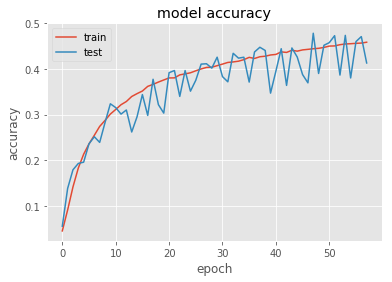

In [97]:
plt.plot(history4.history['acc'])
plt.plot(history4.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

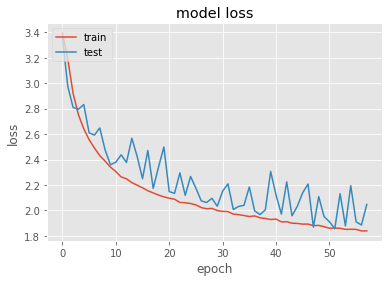

In [98]:
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [103]:
model14 = Sequential()
model14.add(Conv1D(8, 11, activation='relu', input_shape=(8000, 1)))
model14.add(MaxPooling1D(2))
model14.add(Dropout(0.5))
model14.add(Conv1D(16, 7, activation='relu'))
model14.add(MaxPooling1D(2))
model14.add(Dropout(0.5))
model14.add(Conv1D(32, 5, activation='relu'))
model14.add(MaxPooling1D(2))
model14.add(Dropout(0.5))
model14.add(Conv1D(64, 5, activation='relu'))
model14.add(MaxPooling1D(2))
model14.add(Dropout(0.5))
model14.add(Conv1D(128, 3, activation='relu'))
model14.add(MaxPooling1D(2))
# model14.add(Dropout(0.5))
# model14.add(Conv1D(32, 16, activation='relu'))
# model14.add(MaxPooling1D(2))
# model14.add(Dropout(0.5))
# model14.add(Conv1D(64, 8, activation='relu'))
# model14.add(MaxPooling1D(2))
# model14.add(Dropout(0.5))
# model14.add(Conv1D(64, 8, activation='relu'))
# model14.add(MaxPooling1D(2))
# model14.add(Dropout(0.5))
# model14.add(Conv1D(128, 4, activation='relu'))
# model14.add(MaxPooling1D(2))
# model14.add(Dropout(0.5))
# model14.add(Conv1D(128, 4, activation='relu'))
# model14.add(MaxPooling1D(2))
model14.add(Flatten())

model14.add(Dense(256, activation='relu'))
model14.add(Dropout(0.5))
# model14.add(Dense(256, activation='relu'))
# model14.add(Dropout(0.5))
model14.add(Dense(128, activation='relu'))
model14.add(Dropout(0.5))
model14.add(Dense(len(label_value), activation='softmax'))
model14.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_57 (Conv1D)           (None, 7990, 8)           96        
_________________________________________________________________
max_pooling1d_56 (MaxPooling (None, 3995, 8)           0         
_________________________________________________________________
dropout_66 (Dropout)         (None, 3995, 8)           0         
_________________________________________________________________
conv1d_58 (Conv1D)           (None, 3989, 16)          912       
_________________________________________________________________
max_pooling1d_57 (MaxPooling (None, 1994, 16)          0         
_________________________________________________________________
dropout_67 (Dropout)         (None, 1994, 16)          0         
_________________________________________________________________
conv1d_59 (Conv1D)           (None, 1990, 32)          2592      
__________

In [104]:
adam = Adam(lr=0.001)
filepath="new_audio_weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
# reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.2, patience=15, min_lr=0.00001)
earlyStopping = keras.callbacks.EarlyStopping(monitor='val_acc', patience=10)
callbacks_list = [checkpoint, earlyStopping]

In [105]:
parallel_model6 = multi_gpu_model(model14, gpus=4)
parallel_model6.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
history4 = parallel_model6.fit(train_wav, train_label, batch_size=128, epochs=100,
                    validation_data = (cv_wav,cv_label),callbacks = callbacks_list)

Train on 72300 samples, validate on 24100 samples
Epoch 1/100
72300/72300 [==============================] - 25s 346us/step - loss: 3.3701 - acc: 0.0564 - val_loss: 3.3108 - val_acc: 0.0777

Epoch 00001: val_acc improved from -inf to 0.07768, saving model to new_audio_weights.best.hdf5
Epoch 2/100
72300/72300 [==============================] - 21s 285us/step - loss: 3.1273 - acc: 0.1012 - val_loss: 3.0820 - val_acc: 0.0996

Epoch 00002: val_acc improved from 0.07768 to 0.09963, saving model to new_audio_weights.best.hdf5
Epoch 3/100
72300/72300 [==============================] - 21s 285us/step - loss: 2.9018 - acc: 0.1464 - val_loss: 2.8395 - val_acc: 0.1648

Epoch 00003: val_acc improved from 0.09963 to 0.16481, saving model to new_audio_weights.best.hdf5
Epoch 4/100
72300/72300 [==============================] - 21s 285us/step - loss: 2.7582 - acc: 0.1854 - val_loss: 2.7838 - val_acc: 0.1887

Epoch 00004: val_acc improved from 0.16481 to 0.18871, saving model to new_audio_weights.bes


Epoch 00038: val_acc improved from 0.45639 to 0.46461, saving model to new_audio_weights.best.hdf5
Epoch 39/100
72300/72300 [==============================] - 21s 285us/step - loss: 1.8268 - acc: 0.4569 - val_loss: 1.8154 - val_acc: 0.4912

Epoch 00039: val_acc improved from 0.46461 to 0.49120, saving model to new_audio_weights.best.hdf5
Epoch 40/100
72300/72300 [==============================] - 21s 285us/step - loss: 1.8244 - acc: 0.4594 - val_loss: 1.8978 - val_acc: 0.4672

Epoch 00040: val_acc did not improve from 0.49120
Epoch 41/100
72300/72300 [==============================] - 21s 285us/step - loss: 1.8176 - acc: 0.4630 - val_loss: 1.9733 - val_acc: 0.4445

Epoch 00041: val_acc did not improve from 0.49120
Epoch 42/100
72300/72300 [==============================] - 21s 285us/step - loss: 1.8212 - acc: 0.4595 - val_loss: 1.9739 - val_acc: 0.4353

Epoch 00042: val_acc did not improve from 0.49120
Epoch 43/100
72300/72300 [==============================] - 21s 285us/step - loss: 

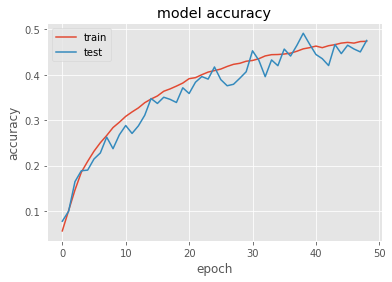

In [106]:
plt.plot(history4.history['acc'])
plt.plot(history4.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

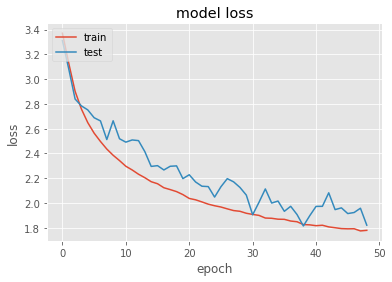

In [107]:
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [108]:
model15 = Sequential()
model15.add(Conv1D(8, 11, activation='relu', input_shape=(8000, 1)))
model15.add(MaxPooling1D(2))
model15.add(Dropout(0.5))
model15.add(Conv1D(16, 7, activation='relu'))
model15.add(MaxPooling1D(2))
model15.add(Dropout(0.5))
model15.add(Conv1D(32, 5, activation='relu'))
model15.add(MaxPooling1D(2))
model15.add(Dropout(0.5))
model15.add(Conv1D(64, 5, activation='relu'))
model15.add(MaxPooling1D(2))
model15.add(Dropout(0.5))
model15.add(Conv1D(128, 3, activation='relu'))
model15.add(MaxPooling1D(2))
# model15.add(Dropout(0.5))
# model15.add(Conv1D(32, 16, activation='relu'))
# model15.add(MaxPooling1D(2))
# model15.add(Dropout(0.5))
# model15.add(Conv1D(64, 8, activation='relu'))
# model15.add(MaxPooling1D(2))
# model15.add(Dropout(0.5))
# model15.add(Conv1D(64, 8, activation='relu'))
# model15.add(MaxPooling1D(2))
# model15.add(Dropout(0.5))
# model15.add(Conv1D(128, 4, activation='relu'))
# model15.add(MaxPooling1D(2))
# model15.add(Dropout(0.5))
# model15.add(Conv1D(128, 4, activation='relu'))
# model15.add(MaxPooling1D(2))
model15.add(Flatten())

model15.add(Dense(256, activation='relu'))
model15.add(Dropout(0.5))
# model15.add(Dense(256, activation='relu'))
# model15.add(Dropout(0.5))
model15.add(Dense(128, activation='relu'))
model15.add(Dropout(0.5))
model15.add(Dense(len(label_value), activation='softmax'))
model15.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_62 (Conv1D)           (None, 7990, 8)           96        
_________________________________________________________________
max_pooling1d_61 (MaxPooling (None, 3995, 8)           0         
_________________________________________________________________
dropout_72 (Dropout)         (None, 3995, 8)           0         
_________________________________________________________________
conv1d_63 (Conv1D)           (None, 3989, 16)          912       
_________________________________________________________________
max_pooling1d_62 (MaxPooling (None, 1994, 16)          0         
_________________________________________________________________
dropout_73 (Dropout)         (None, 1994, 16)          0         
_________________________________________________________________
conv1d_64 (Conv1D)           (None, 1990, 32)          2592      
__________

In [111]:
sgd = SGD(lr=0.01, momentum=0.9)
filepath="new_audio_weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.2, patience=15, min_lr=0.00001)
earlyStopping = keras.callbacks.EarlyStopping(monitor='val_acc', patience=10)
callbacks_list = [reduce_lr, checkpoint, earlyStopping]

In [112]:
parallel_model7 = multi_gpu_model(model15, gpus=4)
parallel_model7.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
history5 = parallel_model7.fit(train_wav, train_label, batch_size=128, epochs=100,
                    validation_data = (cv_wav,cv_label),callbacks = callbacks_list)

Train on 72300 samples, validate on 24100 samples
Epoch 1/100
72300/72300 [==============================] - 23s 325us/step - loss: 3.4118 - acc: 0.0390 - val_loss: 3.4245 - val_acc: 0.0349

Epoch 00001: val_acc improved from -inf to 0.03485, saving model to new_audio_weights.best.hdf5
Epoch 2/100
72300/72300 [==============================] - 19s 266us/step - loss: 3.3950 - acc: 0.0448 - val_loss: 3.4211 - val_acc: 0.0409

Epoch 00002: val_acc improved from 0.03485 to 0.04087, saving model to new_audio_weights.best.hdf5
Epoch 3/100
72300/72300 [==============================] - 19s 268us/step - loss: 3.3911 - acc: 0.0458 - val_loss: 3.4209 - val_acc: 0.0407

Epoch 00003: val_acc did not improve from 0.04087
Epoch 4/100
72300/72300 [==============================] - 19s 266us/step - loss: 3.3871 - acc: 0.0482 - val_loss: 3.4219 - val_acc: 0.0361

Epoch 00004: val_acc did not improve from 0.04087
Epoch 5/100
72300/72300 [==============================] - 19s 267us/step - loss: 3.3788 - 

Epoch 40/100
72300/72300 [==============================] - 19s 266us/step - loss: 2.1527 - acc: 0.3510 - val_loss: 2.4256 - val_acc: 0.3014

Epoch 00040: val_acc improved from 0.24461 to 0.30141, saving model to new_audio_weights.best.hdf5
Epoch 41/100
72300/72300 [==============================] - 19s 267us/step - loss: 2.1466 - acc: 0.3542 - val_loss: 2.4352 - val_acc: 0.2993

Epoch 00041: val_acc did not improve from 0.30141
Epoch 42/100
72300/72300 [==============================] - 19s 266us/step - loss: 2.1003 - acc: 0.3678 - val_loss: 2.5688 - val_acc: 0.2733

Epoch 00042: val_acc did not improve from 0.30141
Epoch 43/100
72300/72300 [==============================] - 19s 267us/step - loss: 2.0875 - acc: 0.3714 - val_loss: 2.4578 - val_acc: 0.2970

Epoch 00043: val_acc did not improve from 0.30141
Epoch 44/100
72300/72300 [==============================] - 19s 266us/step - loss: 2.0641 - acc: 0.3804 - val_loss: 2.4763 - val_acc: 0.3037

Epoch 00044: val_acc improved from 0.3014

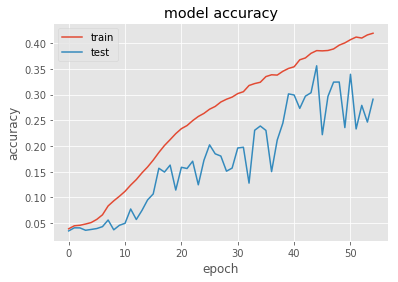

In [116]:
plt.plot(history5.history['acc'])
plt.plot(history5.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

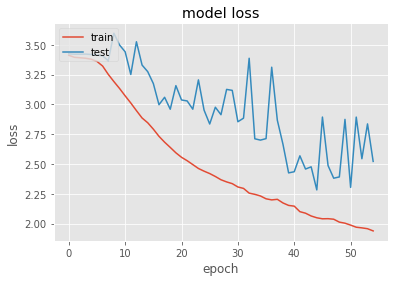

In [115]:
plt.plot(history5.history['loss'])
plt.plot(history5.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Building the model 

In [123]:
model16 = Sequential()
model16.add(Conv1D(32, 9, activation='relu', input_shape=(8000, 1)))
model16.add(BatchNormalization())
model16.add(Conv1D(32, 9, activation='relu'))
model16.add(BatchNormalization())
model16.add(MaxPooling1D(4))
model16.add(Dropout(0.3))

model16.add(Conv1D(64, 9, activation='relu'))
model16.add(BatchNormalization())
model16.add(Conv1D(64, 9, activation='relu'))
model16.add(BatchNormalization())
model16.add(MaxPooling1D(4))
model16.add(Dropout(0.3))

model16.add(Conv1D(128, 9, activation='relu'))
model16.add(BatchNormalization())
model16.add(Conv1D(128, 9, activation='relu'))
model16.add(BatchNormalization())
model16.add(MaxPooling1D(4))
model16.add(Dropout(0.3))

model16.add(Conv1D(256, 9, activation='relu'))
model16.add(BatchNormalization())
model16.add(Conv1D(256, 9, activation='relu'))
model16.add(BatchNormalization())
model16.add(MaxPooling1D(4))
model16.add(Dropout(0.3))

model16.add(Conv1D(512, 9, activation='relu'))
model16.add(BatchNormalization())
model16.add(Conv1D(512, 9, activation='relu'))
model16.add(BatchNormalization())
model16.add(MaxPooling1D(4))
model16.add(Dropout(0.3))
model16.add(Flatten())

model16.add(Dense(2048, activation='relu'))
model16.add(Dropout(0.3))
model16.add(Dense(2048, activation='relu'))
model16.add(Dropout(0.3))
model16.add(Dense(len(label_value), activation='softmax'))
model16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_87 (Conv1D)           (None, 7992, 32)          320       
_________________________________________________________________
batch_normalization_21 (Batc (None, 7992, 32)          128       
_________________________________________________________________
conv1d_88 (Conv1D)           (None, 7984, 32)          9248      
_________________________________________________________________
batch_normalization_22 (Batc (None, 7984, 32)          128       
_________________________________________________________________
max_pooling1d_76 (MaxPooling (None, 1996, 32)          0         
_________________________________________________________________
dropout_92 (Dropout)         (None, 1996, 32)          0         
_________________________________________________________________
conv1d_89 (Conv1D)           (None, 1988, 64)          18496     
__________

In [124]:
adam = Adam(lr=0.001)
filepath="new_audio_weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
# reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.2, patience=15, min_lr=0.00001)
earlyStopping = keras.callbacks.EarlyStopping(monitor='val_acc', patience=15)
callbacks_list = [checkpoint, earlyStopping]

## Using parallel GPU's

In [125]:
parallel_model8 = multi_gpu_model(model16, gpus=4)
parallel_model8.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
history6 = parallel_model8.fit(train_wav, train_label, batch_size=128, epochs=100,
                    validation_data = (cv_wav,cv_label),callbacks = callbacks_list)

Train on 72300 samples, validate on 24100 samples
Epoch 1/100
72300/72300 [==============================] - 62s 860us/step - loss: 2.7493 - acc: 0.2209 - val_loss: 3.0057 - val_acc: 0.3056

Epoch 00001: val_acc improved from -inf to 0.30556, saving model to new_audio_weights.best.hdf5
Epoch 2/100
72300/72300 [==============================] - 48s 663us/step - loss: 1.5083 - acc: 0.5561 - val_loss: 1.1529 - val_acc: 0.6600

Epoch 00002: val_acc improved from 0.30556 to 0.65996, saving model to new_audio_weights.best.hdf5
Epoch 3/100
72300/72300 [==============================] - 48s 663us/step - loss: 1.1223 - acc: 0.6678 - val_loss: 1.0535 - val_acc: 0.6883

Epoch 00003: val_acc improved from 0.65996 to 0.68830, saving model to new_audio_weights.best.hdf5
Epoch 4/100
72300/72300 [==============================] - 48s 663us/step - loss: 0.9474 - acc: 0.7219 - val_loss: 0.9376 - val_acc: 0.7218

Epoch 00004: val_acc improved from 0.68830 to 0.72183, saving model to new_audio_weights.bes

## Plotting the model accuracy and model loss graph

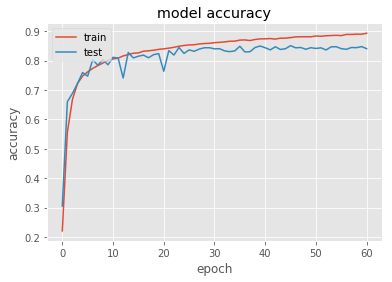

In [126]:
plt.plot(history6.history['acc'])
plt.plot(history6.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

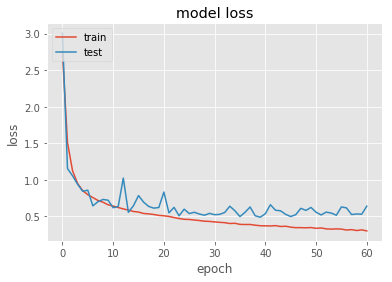

In [127]:
plt.plot(history6.history['loss'])
plt.plot(history6.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [128]:
eval = parallel_model8.evaluate(test_wav, test_label)

24100/24100 [==============================] - 18s 754us/step


## Evaluating the test accuracy

In [131]:
print('Test Loss is ' + str(eval[0]))
print('Test Accuracy is ' + str(eval[1]))

Test Loss is 0.6094324428708722
Test Accuracy is 0.8446473029045644


## Output generated by live recording 

In [5]:
import pyaudio
import wave

CHUNK = 4000
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 8000
RECORD_SECONDS = 1
WAVE_OUTPUT_FILENAME = "output.wav"

p = pyaudio.PyAudio()

stream = p.open(format=FORMAT,
                channels=CHANNELS,
                rate=RATE,
                input=True,
                frames_per_buffer=CHUNK)

print("* recording")

frames = []

for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
    data = stream.read(CHUNK)
    frames.append(data)

print("* done recording")

stream.stop_stream()
stream.close()
p.terminate()

wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
wf.setnchannels(CHANNELS)
wf.setsampwidth(p.get_sample_size(FORMAT))
wf.setframerate(RATE)
wf.writeframes(b''.join(frames))
wf.close()

* recording
* done recording


In [2]:
loaded_model = load_model('new_audio_weights.best.hdf5')

In [3]:
target = ['bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'four', 'go', 'happy', 'house', 'left',
          'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three',
          'tree', 'two', 'up', 'wow', 'yes', 'zero', 'silence']

In [4]:
def predictText(fileName):
    samples, sample_rate = librosa.load((fileName), sr = 8000)
    samples = librosa.resample(samples, sample_rate, 8000)
    samples = np.reshape(samples,(-1, 8000, 1))
    pred = loaded_model.predict(samples)
    print(target[np.argmax(pred)])

## The text generated after the translatio of the recording 

In [6]:
predictText('output.wav')

three


In [88]:
predictText('output2.wav')

dog


## References 

1. https://arxiv.org/pdf/1609.09430.pdf
2. https://www.kaggle.com/kcs93023/keras-sequential-conv1d-model-classification/notebook
3. https://medium.com/@saxenauts/speech-synthesis-techniques-using-deep-neural-networks-38699e943861
4. https://www.analyticsvidhya.com/blog/2017/08/audio-voice-processing-deep-learning/
5. http://aqibsaeed.github.io/2016-09-24-urban-sound-classification-part-2/
6. https://gist.github.com/jaron/5b17c9f37f351780744aefc74f93d3ae
7. https://towardsdatascience.com/whats-wrong-with-spectrograms-and-cnns-for-audio-processing-311377d7ccd
8. https://musicinformationretrieval.com/mfcc.html
9. https://en.wikipedia.org/wiki/Spectrogram